In [162]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
pd.set_option('display.float_format', '{:.2f}'.format)


In [163]:
load_dotenv()

# Obtener las variables de entorno
server = os.getenv('SERVER')
database = 'ewise_BI_Esm'
username = os.getenv('SQL_USERNAME')
password = os.getenv('SQL_PASSWORD')
##%%
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
# connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [226]:
query = """ 
BEGIN
    DECLARE @TotalRows INT;

    -- Contar el total de filas excluyendo a los jugadores perdidos
    SELECT @TotalRows = COUNT(*)
    FROM dbo.BI_GAME_SESSIONS gs
    INNER JOIN dbo.BI_CARDS crd ON crd.CARD_ID = gs.CARD_ID
    INNER JOIN dbo.BI_PLAYERS pl ON pl.PLAYER_ID = crd.PLAYER_ID
    INNER JOIN dbo.BI_PLAYERS_LEVEL_ASSIGNED pll ON pll.PLAYER_ID = pl.PLAYER_ID
    WHERE gs.INITIAL_TIME >= '2024-01-01'

    DECLARE @SampleSize INT;
    SET @SampleSize = CEILING(@TotalRows * 0.01);

    -- Seleccionar la muestra excluyendo a los jugadores perdidos
    SELECT TOP (@SampleSize)
           pl.PLAYER_ID,
           pl.DOB,
           pl.GENDER,
           gs.AVG_BET,
           gs.BET_TOTAL,
           gs.INITIAL_AMOUNT,
           gs.INITIAL_PROMO_AMOUNT,
           gs.FINAL_AMOUNT,
           gs.FINAL_PROMO_AMOUNT,
           gs.MACHINE_ID,
           gs.WIN_TOTAL,
           gs.GAMES_PLAYED_TOTAL,
           gs.GAMES_WON_TOTAL,
           gs.TIME_ON_DEVICE_SEC,
           pll.PLAYER_LEVEL_ID

            -- Agrega el campo que necesitas de BI_REPORT_DAILYMETERS
    FROM dbo.BI_GAME_SESSIONS gs
    INNER JOIN dbo.BI_CARDS crd ON crd.CARD_ID = gs.CARD_ID
    INNER JOIN dbo.BI_PLAYERS pl ON pl.PLAYER_ID = crd.PLAYER_ID
    INNER JOIN dbo.BI_PLAYERS_LEVEL_ASSIGNED pll ON pll.PLAYER_ID = pl.PLAYER_ID
    WHERE gs.INITIAL_TIME >= '2024-01-01'
    ORDER BY CHECKSUM(NEWID());
END
"""

In [227]:
df = pd.read_sql_query(query, engine)

In [228]:
df.head(3)

,PLAYER_ID,DOB,GENDER,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,MACHINE_ID,WIN_TOTAL,GAMES_PLAYED_TOTAL,GAMES_WON_TOTAL,TIME_ON_DEVICE_SEC,PLAYER_LEVEL_ID
0,8C3C614A-E51A-4662-A1F5-57CB29A85A24,1977-04-26,F,8.66,5462.50,8182.68,0.00,6222.43,0.00,FEAD1329-51D4-425F-8BFC-8B6949F66A34,3502.25,631.00,164.00,2628.00,1
1,1C1FF7AD-E261-434A-87CC-1B0C34A459E2,1970-07-05,F,2.20,81.50,0.00,121.67,0.00,65.42,FF19E451-6E89-49F4-A7AF-93297E37133A,25.25,37.00,6.00,228.00,1
2,8ABB9F59-0CF4-481D-9FD7-9EBC7B64C140,1949-07-25,F,2.50,10.00,10.79,0.00,0.79,0.00,F67E846F-ED4A-491B-9D89-0F15455E9EB5,0.00,4.00,0.00,216.00,3


In [229]:
df = df.loc[df['GAMES_PLAYED_TOTAL'] < 90000]
df.describe()

,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,WIN_TOTAL,GAMES_PLAYED_TOTAL,GAMES_WON_TOTAL,TIME_ON_DEVICE_SEC,PLAYER_LEVEL_ID
count,5019.00,5019.00,5019.00,5019.00,5019.00,5019.00,5019.00,5019.00,5019.00,5018.00,5019.00
mean,8.48,1627.58,647.18,28.86,577.98,22.55,-1127.72,160.86,52.10,742.68,3.36
std,18.64,11271.40,1320.16,117.07,2785.01,93.84,47967.08,371.86,118.90,1361.94,2.24
min,0.00,0.00,0.00,0.00,0.00,0.00,-999556.95,0.00,0.00,4.00,1.00
25%,2.50,106.00,173.89,0.00,1.76,0.00,40.00,28.00,8.00,131.00,1.00
50%,4.40,363.00,302.37,0.00,101.92,0.00,205.65,73.00,23.00,330.00,3.00
75%,8.72,1120.00,601.86,0.00,493.13,0.00,880.52,171.00,55.00,809.75,5.00
max,550.85,699072.00,43071.93,2994.00,131167.43,1888.79,219347.50,17136.00,4699.00,37871.00,8.00


In [230]:
df = df.dropna()

In [231]:
df .select_dtypes(include=['number']).columns

Index(['AVG_BET', 'BET_TOTAL', 'INITIAL_AMOUNT', 'INITIAL_PROMO_AMOUNT',
       'FINAL_AMOUNT', 'FINAL_PROMO_AMOUNT', 'WIN_TOTAL', 'GAMES_PLAYED_TOTAL',
       'GAMES_WON_TOTAL', 'TIME_ON_DEVICE_SEC', 'PLAYER_LEVEL_ID'],
      dtype='object')

In [232]:
from sklearn.preprocessing import StandardScaler

# 1. Seleccionar las columnas numéricas
num_cols = df.select_dtypes(include=['number']).columns

# 2. Excluir 'PLAYER_LEVEL_ID'
cols_to_scale = num_cols.drop('PLAYER_LEVEL_ID')

# 3. Instanciar el StandardScaler
scaler = StandardScaler()

# 4. Ajustar y transformar las columnas
scaled_values = scaler.fit_transform(df[cols_to_scale])

# 5. Crear nuevas columnas con sufijo '_std'
scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_std" for col in cols_to_scale], index=df.index)

# 6. Concatenar al dataframe original
df = pd.concat([df, scaled_df], axis=1)


In [233]:
df.head()

,PLAYER_ID,DOB,GENDER,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,MACHINE_ID,...,AVG_BET_std,BET_TOTAL_std,INITIAL_AMOUNT_std,INITIAL_PROMO_AMOUNT_std,FINAL_AMOUNT_std,FINAL_PROMO_AMOUNT_std,WIN_TOTAL_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,TIME_ON_DEVICE_SEC_std
0,8C3C614A-E51A-4662-A1F5-57CB29A85A24,1977-04-26,F,8.66,5462.50,8182.68,0.00,6222.43,0.00,FEAD1329-51D4-425F-8BFC-8B6949F66A34,...,0.01,0.34,5.71,-0.25,2.03,-0.24,0.10,1.26,0.94,1.38
1,1C1FF7AD-E261-434A-87CC-1B0C34A459E2,1970-07-05,F,2.20,81.50,0.00,121.67,0.00,65.42,FF19E451-6E89-49F4-A7AF-93297E37133A,...,-0.34,-0.14,-0.49,0.79,-0.21,0.46,0.02,-0.33,-0.39,-0.38
2,8ABB9F59-0CF4-481D-9FD7-9EBC7B64C140,1949-07-25,F,2.50,10.00,10.79,0.00,0.79,0.00,F67E846F-ED4A-491B-9D89-0F15455E9EB5,...,-0.32,-0.14,-0.48,-0.25,-0.21,-0.24,0.02,-0.42,-0.44,-0.39
3,8B45E0AD-34FF-499E-91A8-2A72C48B6874,1971-03-22,F,16.43,887.40,1504.10,0.00,812.20,0.00,D9D84955-9FA2-49A1-B0DF-D336A88CBBC7,...,0.43,-0.07,0.65,-0.25,0.08,-0.24,0.03,-0.29,-0.23,-0.48
4,835BA320-D7A2-4F01-BC05-C6CB2A45796A,1945-02-28,M,2.00,38.00,400.19,0.00,379.44,0.00,92CDEF60-8604-4DF0-8D86-81325E394385,...,-0.35,-0.14,-0.19,-0.25,-0.07,-0.24,0.02,-0.38,-0.39,-0.48


In [234]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df ['GENDER'] = le.fit_transform(df['GENDER'])

In [235]:
df['DOB'] = pd.to_datetime(df['DOB'])
hoy = datetime.now()
df['Edad'] = hoy.year - df['DOB'].dt.year
df['Edad'] -= ((hoy.month < df['DOB'].dt.month) | 
               ((hoy.month == df['DOB'].dt.month) & 
                (hoy.day < df['DOB'].dt.day)))

bins = [18, 25, 35, 45, 55, 65, 100]  # 100 es un valor arbitrario para cubrir edades mayores a 65
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Crear la columna 'Rango_Edad'
df['Rango_Edad'] = pd.cut(df['Edad'], bins=bins, labels=labels, right=False)

In [236]:
le_edad = LabelEncoder()
df['Rango_Edad_le'] = le_edad.fit_transform(df['Rango_Edad'])

In [237]:
df.head()

,PLAYER_ID,DOB,GENDER,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,MACHINE_ID,...,INITIAL_PROMO_AMOUNT_std,FINAL_AMOUNT_std,FINAL_PROMO_AMOUNT_std,WIN_TOTAL_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,TIME_ON_DEVICE_SEC_std,Edad,Rango_Edad,Rango_Edad_le
0,8C3C614A-E51A-4662-A1F5-57CB29A85A24,1977-04-26,0,8.66,5462.50,8182.68,0.00,6222.43,0.00,FEAD1329-51D4-425F-8BFC-8B6949F66A34,...,-0.25,2.03,-0.24,0.10,1.26,0.94,1.38,48,45-54,3
1,1C1FF7AD-E261-434A-87CC-1B0C34A459E2,1970-07-05,0,2.20,81.50,0.00,121.67,0.00,65.42,FF19E451-6E89-49F4-A7AF-93297E37133A,...,0.79,-0.21,0.46,0.02,-0.33,-0.39,-0.38,55,55-64,4
2,8ABB9F59-0CF4-481D-9FD7-9EBC7B64C140,1949-07-25,0,2.50,10.00,10.79,0.00,0.79,0.00,F67E846F-ED4A-491B-9D89-0F15455E9EB5,...,-0.25,-0.21,-0.24,0.02,-0.42,-0.44,-0.39,76,65+,5
3,8B45E0AD-34FF-499E-91A8-2A72C48B6874,1971-03-22,0,16.43,887.40,1504.10,0.00,812.20,0.00,D9D84955-9FA2-49A1-B0DF-D336A88CBBC7,...,-0.25,0.08,-0.24,0.03,-0.29,-0.23,-0.48,54,45-54,3
4,835BA320-D7A2-4F01-BC05-C6CB2A45796A,1945-02-28,1,2.00,38.00,400.19,0.00,379.44,0.00,92CDEF60-8604-4DF0-8D86-81325E394385,...,-0.25,-0.07,-0.24,0.02,-0.38,-0.39,-0.48,80,65+,5


In [238]:
columns_selected = ['GENDER',  'AVG_BET_std',
       'INITIAL_AMOUNT_std',  'FINAL_AMOUNT_std',
        'GAMES_PLAYED_TOTAL_std',
       'GAMES_WON_TOTAL_std', 'Rango_Edad_le']
df_scaled = df[columns_selected]

In [239]:
df_scaled.head()

,GENDER,AVG_BET_std,INITIAL_AMOUNT_std,FINAL_AMOUNT_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,Rango_Edad_le
0,0,0.01,5.71,2.03,1.26,0.94,3
1,0,-0.34,-0.49,-0.21,-0.33,-0.39,4
2,0,-0.32,-0.48,-0.21,-0.42,-0.44,5
3,0,0.43,0.65,0.08,-0.29,-0.23,3
4,1,-0.35,-0.19,-0.07,-0.38,-0.39,5


In [240]:
from sklearn.cluster import KMeans
wcss = []# Asegurarse de que no haya valores NaN
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)


In [241]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')

Text(0.5, 1.0, 'Elbow Method for Optimal K')

In [242]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_scaled)

KMeans(n_clusters=2, random_state=42)

In [243]:

df['Cluster'] = kmeans.labels_

In [244]:
df_cluster1 = df[df['Cluster'] == 0]
df_cluster2 = df[df['Cluster'] == 1]

In [245]:
df_cluster1.describe()

,DOB,GENDER,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,WIN_TOTAL,GAMES_PLAYED_TOTAL,...,INITIAL_PROMO_AMOUNT_std,FINAL_AMOUNT_std,FINAL_PROMO_AMOUNT_std,WIN_TOTAL_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,TIME_ON_DEVICE_SEC_std,Edad,Rango_Edad_le,Cluster
count,5017,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,...,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00,5017.00
mean,1967-02-28 07:15:59.378114416,0.30,8.48,1627.67,647.32,28.81,578.21,22.56,-1128.54,157.46,...,0.00,0.00,0.00,-0.00,-0.01,-0.01,-0.00,57.93,3.75,0.00
min,1932-12-31 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-999556.95,0.00,...,-0.25,-0.21,-0.24,-20.81,-0.43,-0.44,-0.54,18.00,0.00,0.00
25%,1958-07-15 00:00:00,0.00,2.50,106.00,173.95,0.00,1.76,0.00,40.00,28.00,...,-0.25,-0.21,-0.24,0.02,-0.36,-0.37,-0.45,50.00,3.00,0.00
50%,1964-10-04 00:00:00,0.00,4.40,362.50,302.37,0.00,101.94,0.00,205.00,73.00,...,-0.25,-0.17,-0.24,0.03,-0.24,-0.24,-0.30,60.00,4.00,0.00
75%,1974-08-17 00:00:00,1.00,8.72,1120.00,601.97,0.00,493.20,0.00,880.00,171.00,...,-0.25,-0.03,-0.24,0.04,0.03,0.02,0.05,67.00,5.00,0.00
max,2007-01-12 00:00:00,1.00,550.85,699072.00,43071.93,2994.00,131167.43,1888.79,219347.50,5388.00,...,25.34,46.89,19.89,4.60,14.06,16.64,27.26,92.00,5.00,0.00
std,NaN,0.46,18.64,11273.64,1320.40,117.03,2785.54,93.85,47976.62,284.38,...,1.00,1.00,1.00,1.00,0.76,0.83,1.00,13.73,1.27,0.00


In [246]:
df_cluster2.describe()

,DOB,GENDER,AVG_BET,BET_TOTAL,INITIAL_AMOUNT,INITIAL_PROMO_AMOUNT,FINAL_AMOUNT,FINAL_PROMO_AMOUNT,WIN_TOTAL,GAMES_PLAYED_TOTAL,...,INITIAL_PROMO_AMOUNT_std,FINAL_AMOUNT_std,FINAL_PROMO_AMOUNT_std,WIN_TOTAL_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,TIME_ON_DEVICE_SEC_std,Edad,Rango_Edad_le,Cluster
count,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
mean,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
min,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
25%,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
50%,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
75%,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
max,1973-08-18 00:00:00,0.00,10.82,2011.10,502.65,0.00,2.80,0.00,1520.05,17136.00,...,-0.25,-0.21,-0.24,0.06,45.65,39.08,0.23,51.00,3.00,1.00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
df_scaled.corr()

,GENDER,AVG_BET_std,INITIAL_AMOUNT_std,FINAL_AMOUNT_std,GAMES_PLAYED_TOTAL_std,GAMES_WON_TOTAL_std,Rango_Edad_le
GENDER,1.00,0.05,0.06,0.03,-0.01,-0.02,-0.14
AVG_BET_std,0.05,1.00,0.53,0.40,0.04,0.08,-0.07
INITIAL_AMOUNT_std,0.06,0.53,1.00,0.68,0.09,0.10,-0.06
FINAL_AMOUNT_std,0.03,0.40,0.68,1.00,0.07,0.07,-0.03
GAMES_PLAYED_TOTAL_std,-0.01,0.04,0.09,0.07,1.00,0.93,-0.00
GAMES_WON_TOTAL_std,-0.02,0.08,0.10,0.07,0.93,1.00,-0.01
Rango_Edad_le,-0.14,-0.07,-0.06,-0.03,-0.00,-0.01,1.00


In [248]:
from pycaret.clustering import *
cluster = setup(data=df_scaled, session_id=42)

,Description,Value
0,Session id,42
1,Original data shape,"(5018, 7)"
2,Transformed data shape,"(5018, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [249]:
model = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4033,1184.2896,1.0270,0,0,0


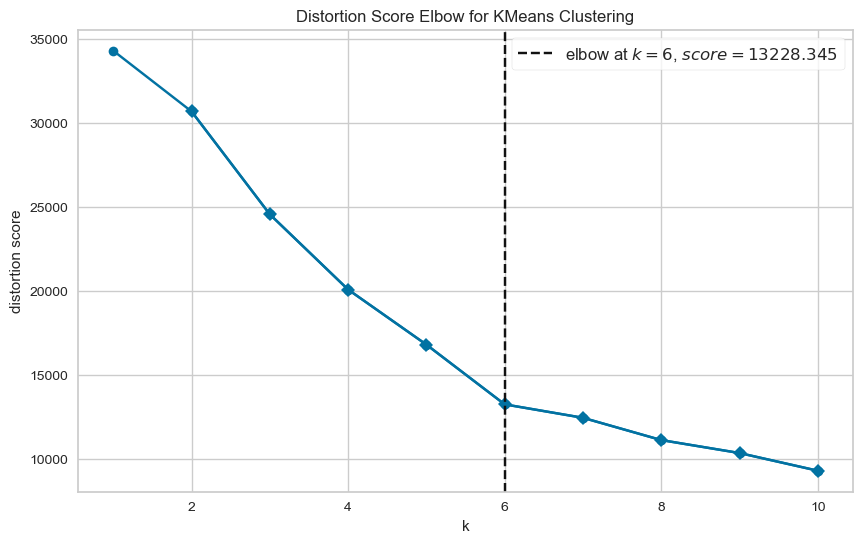

In [250]:
plot_model(model, plot='elbow')

In [251]:
model = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4033,1184.2896,1.0270,0,0,0


In [252]:
results = assign_model(model)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

components = pca.fit_transform(df_scaled)
df['Cluster'] = results['Cluster']
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]


In [254]:
df.groupby('Cluster').agg({
    'Edad': 'mean',
    'AVG_BET': 'mean',
    'INITIAL_AMOUNT': 'mean',
    'FINAL_AMOUNT': 'mean',
    'GAMES_PLAYED_TOTAL': 'mean',
    'GAMES_WON_TOTAL': 'mean',
}).reset_index()

,Cluster,Edad,AVG_BET,INITIAL_AMOUNT,FINAL_AMOUNT,GAMES_PLAYED_TOTAL,GAMES_WON_TOTAL
0,Cluster 0,42.41,7.66,531.32,392.44,140.28,45.79
1,Cluster 1,51.00,10.82,502.65,2.80,17136.00,4699.00
2,Cluster 2,66.03,6.38,499.56,395.43,139.54,44.18
3,Cluster 3,54.00,64.16,5218.85,6710.01,746.73,265.57


In [255]:
df_custer1 = df.loc[df['Cluster'] == 'Cluster 3']

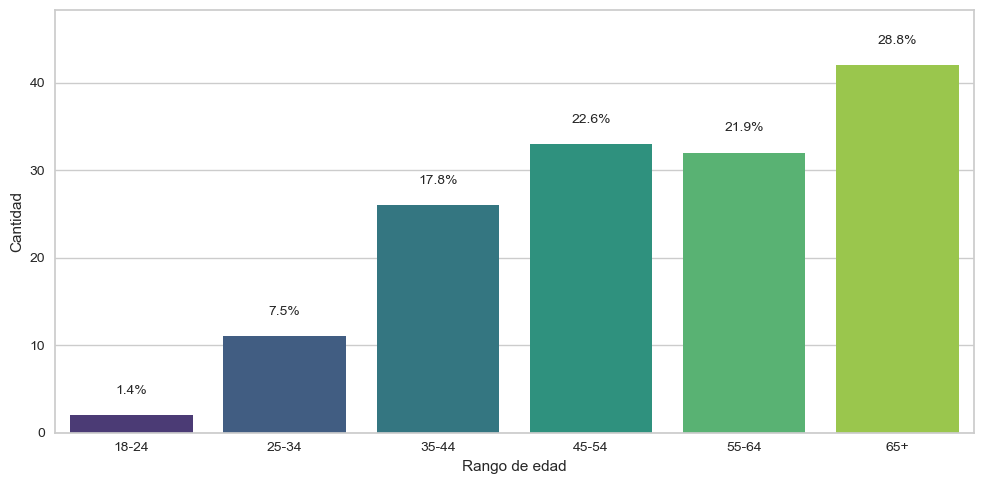

In [256]:
rangos_edad = df_custer1.groupby('Rango_Edad').size().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=rangos_edad['Rango_Edad'], y=rangos_edad[0], palette='viridis')

# Calcular porcentajes
total = sum(rangos_edad[0])
porcentajes = [(valor / total) * 100 for valor in rangos_edad[0]]

# Ajustar la posición de los textos
max_y = max(rangos_edad[0])  # Valor máximo del eje Y
for i, (valor, porcentaje) in enumerate(zip(rangos_edad[0], porcentajes)):
    plt.text(
        i,                              # Posición X (centrada en la barra)
        valor + (0.05 * max_y),          # Posición Y (un 5% por encima de la barra)
        f'{porcentaje:.1f}%',            # Texto (porcentaje)
        ha='center',                     # Alineación horizontal
        va='bottom',                     # Alineación vertical
        fontsize=10                      # Tamaño de la fuente
    )

# Ajustar límites del eje Y para dar espacio a los textos
plt.ylim(0, max_y * 1.15)  # Aumenta el límite superior en un 15%

# Etiquetas y título
plt.xlabel("Rango de edad")
plt.ylabel('Cantidad')
plt.tight_layout()

# Mostrar el gráfico
plt.show()
